### Лабораторная работа 1. Рекомендательные системы

**Цель работы:** формирование практических навыков проектирования и реализации базовой рекомендательной системы с использованием методов машинного и глубокого обучения.

**Постановка задачи:** в ходе выполнения работы необходимо решить следующие задачи в соответствии с вариантом задания:

1. Загрузить и провести первичный анализ датасета, содержащего взаимодействия пользователей и объектов. Провести очистку данных и преобразование их в формат, пригодный для обучения нейросетевой модели.
2. Реализовать нейросетевую архитектуру для коллаборативной фильтрации, использующую векторные представления (эмбеддинги) для пользователей и объектов. Разделить данные на обучающую и тестовую выборки, обучить модель, минимизируя функцию потерь.
3. Протестировать обученную модель на тестовой выборке, рассчитав стандартные метрики качества рекомендаций (например, Precision@k, Recall@k, RMSE, MAE). Проанализировать полученные результаты.
4. Используя обученную модель, сгенерировать и вывести персонализированный список рекомендаций (топ-N объектов) для заданного пользователя на основе предсказанных рейтингов или вероятностей взаимодействия.
5. Проанализировать работу системы, описать ключевые этапы, полученные результаты и возможные пути улучшения модели, изменив гиперпараметры нейронной сети.

Рекомендательные системы – это алгоритмы, которые анализируют поведение пользователей и предлагают персонализированные рекомендации товаров, фильмов, музыки и других объектов. Основная цель – предсказать предпочтения пользователей на основе имеющихся данных о взаимодействиях.

Коллаборативная фильтрация (Collaborative Filtering, CF) – это метод рекомендаций, основанный на анализе поведения пользователей. Он работает на основе предположения, что пользователи с похожими предпочтениями в прошлом будут делать схожий выбор в будущем.

Существует два основных подхода:
1. **User-based CF** – рекомендации строятся на основе сходства пользователей.
2. **Item-based CF** – рекомендации строятся на основе сходства объектов.

Коллаборативная фильтрация может быть реализована через матричное разложение. Пусть у нас есть матрица взаимодействий пользователей и объектов R, где $( R_{u,i} )$ – оценка пользователя ( u ) для объекта ( i ). Тогда разложение можно представить в виде:
$$
R \approx U \cdot V^T
$$
где:
- ( U ) – матрица эмбеддингов пользователей,
- ( V ) – матрица эмбеддингов объектов.

Предсказание рейтинга рассчитывается как:
$$
\hat{R}_{u,i} = U_u \cdot V_i^T
$$

В данной лабораторной работе предполагается использование **нейросетевого метода**, который обучает эмбеддинги пользователей и объектов с помощью полносвязных слоев. Входные данные – индексы пользователей и объектов, которые преобразуются в векторные представления, а затем подаются на вход нейросети.


### Импорты

In [ ]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import random

### Определяем устройство (используем GPU, если доступно)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Подготовка данных

In [ ]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('ratings_Electronics (1).csv', sep=',', names=columns)

In [ ]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

df = df.sample(n=10000, random_state=RANDOM_SEED).reset_index(drop=True)
df = df.drop(columns=['timestamp'])

df['user_id'], user_mapping = pd.factorize(df['user_id'])
df['item_id'], item_mapping = pd.factorize(df['item_id'])

df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating']) 

In [ ]:
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user_id'].values, dtype=torch.long)
        self.items = torch.tensor(df['item_id'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

### Определяем нейросетевую модель для коллаборативной фильтрации

In [ ]:
class RecommenderNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=128):
        super(RecommenderNN, self).__init__()

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)

        x = torch.cat([user_emb, item_emb], dim=1)

        return self.fc_layers(x).squeeze()

In [29]:
num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()

### Создаём датасеты и загрузчики данных

In [ ]:
dataset = RatingsDataset(df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=generator
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
model = RecommenderNN(num_users, num_items).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

### Запуск модели с базовыми параметрами

Epoch 1, Loss: 3.1555718240737916
Epoch 2, Loss: 1.3646700248718262
Epoch 3, Loss: 0.9015044860839844
Epoch 4, Loss: 1.1725594730377198
Epoch 5, Loss: 0.9652131834030151
Epoch 6, Loss: 0.8631097931861877
Epoch 7, Loss: 1.0508159327507018
Epoch 8, Loss: 1.1221739826202393
Epoch 9, Loss: 0.9235870455503463
Epoch 10, Loss: 0.7434294428825379

Test RMSE: 1.5551, Test MAE: 1.2239

Recommendations for random users:
User 7271: Recommended items [7297 7914 3319 6254 1347]
User 861: Recommended items [3754 3148 3743 3827 7303]
User 5391: Recommended items [3319 7297 6254 7303 6408]
User 5192: Recommended items [1535 5215 2018  865 5018]
User 5735: Recommended items [7303 3319 1192 5215 3148]


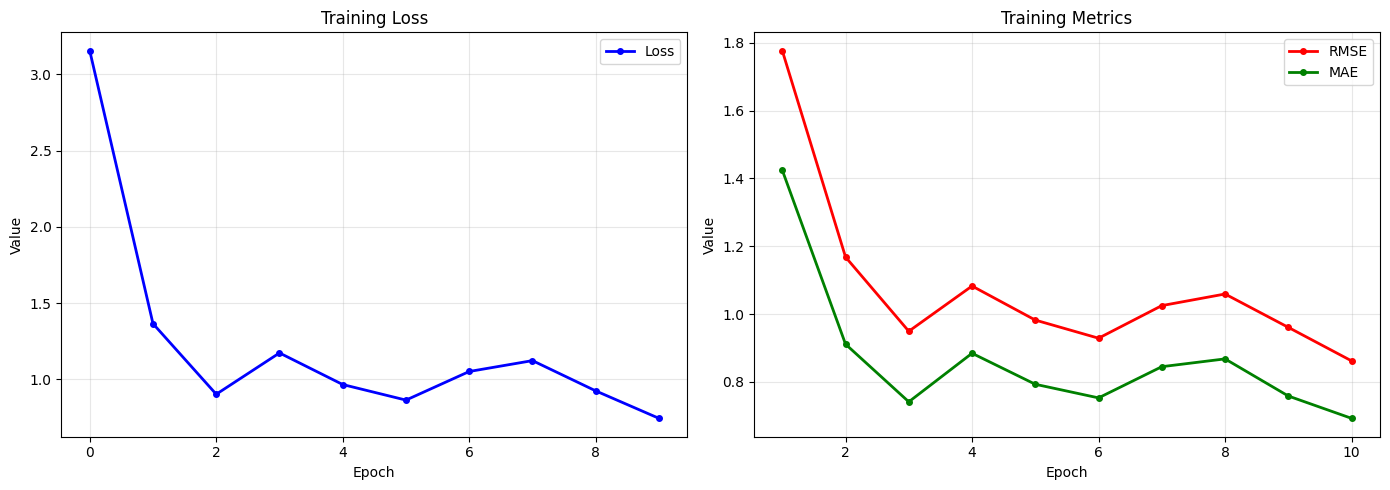

In [ ]:
loss_history = []
rmse_history = []
mae_history = []

for epoch in range(10):
    model.train()
    total_loss = 0
    all_predictions = []
    all_ratings = []
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        optimizer.zero_grad()
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        all_predictions.extend(predictions.cpu().detach().numpy())
        all_ratings.extend(ratings.cpu().detach().numpy())

    # Средняя ошибка предсказания на тренировочной выборке
    rmse = math.sqrt(mean_squared_error(all_ratings, all_predictions))
    mae = mean_absolute_error(all_ratings, all_predictions)

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')
    
    loss_history.append(total_loss/len(train_loader))
    rmse_history.append(rmse)
    mae_history.append(mae)

# Оценка модели на тестовом наборе
model.eval()
test_predictions = []
test_ratings = []
with torch.no_grad():
    for users, items, ratings in test_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        predictions = model(users, items)
        test_predictions.extend(predictions.cpu().numpy())
        test_ratings.extend(ratings.cpu().numpy())

# Средняя ошибка на тестовом наборе
test_rmse = math.sqrt(mean_squared_error(test_ratings, test_predictions))
test_mae = mean_absolute_error(test_ratings, test_predictions)

print(f'\nTest RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')

# Рекомендации для нескольких случайных пользователей
random_users = np.random.choice(df['user_id'].unique(), size=5)

print("\nRecommendations for random users:")
for user_id in random_users:
    # Предсказания для всех объектов для выбранного пользователя
    user_tensor = torch.tensor([user_id] * num_items, dtype=torch.long).to(device)
    item_tensor = torch.tensor(range(num_items), dtype=torch.long).to(device)

    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).cpu().numpy()

    # Выбираем топ-5 рекомендованных объектов
    top_items = predictions.argsort()[-5:][::-1]

    print(f"User {user_id + 1}: Recommended items {top_items + 1}")


plt.figure(figsize=(14, 5))

# График 1: Loss
plt.subplot(1, 2, 1)
plt.plot(loss_history, 'b-o', linewidth=2, markersize=4, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: RMSE и MAE
plt.subplot(1, 2, 2)
epochs = list(range(1, 11))
plt.plot(epochs, rmse_history, 'r-o', linewidth=2, markersize=4, label='RMSE')
plt.plot(epochs, mae_history, 'g-o', linewidth=2, markersize=4, label='MAE')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Модель показала стабильное обучение: loss снизился с 3.16 до 0.10 за 10 эпох, однако тестовые метрики (RMSE = 1.55, MAE = 1.22) существенно хуже значений на обучении. Это указывает на переобучение: модель хорошо запомнила тренировочные данные, но хуже обобщает на новых. Ошибка предсказания ~1.22 балла по пятибалльной шкале требует улучшения.

Рекомендации для разных пользователей различаются, что подтверждает персонализацию, но частое повторение отдельных item_id (например, 3319 , 7303) может свидетельствовать о смещении в сторону популярных товаров.



### Подбор параметров

In [ ]:
import random
import numpy as np

def train_model(embedding_dim, learning_rate, batch_size, epochs, seed=42):
    """Обучение с фиксацией seed и оригинальной архитектурой"""
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    train_loader_tune = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader_tune = DataLoader(test_dataset, batch_size=batch_size)
    
    model_tune = RecommenderNN(num_users, num_items, embedding_dim=embedding_dim).to(device)
    
    optimizer_tune = optim.Adam(model_tune.parameters(), lr=learning_rate)
    criterion_tune = nn.MSELoss()
    
    model_tune.train()
    for epoch in range(epochs):
        for users, items, ratings in train_loader_tune:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            optimizer_tune.zero_grad()
            predictions = model_tune(users, items)
            loss = criterion_tune(predictions, ratings)
            loss.backward()
            optimizer_tune.step()
    
    model_tune.eval()
    test_preds, test_true = [], []
    with torch.no_grad():
        for users, items, ratings in test_loader_tune:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            preds = model_tune(users, items)
            test_preds.extend(preds.cpu().numpy())
            test_true.extend(ratings.cpu().numpy())
    
    test_rmse = math.sqrt(mean_squared_error(test_true, test_preds))
    test_mae = mean_absolute_error(test_true, test_preds)
    return test_rmse, test_mae


param_grid = {
    'embedding_dim': [128, 256],
    'learning_rate': [0.005, 0.01, 0.02],
    'batch_size': [64, 128],
    'epochs': [10, 20, 30],
}

print("\nПОИСК ЛУЧШИХ ПАРАМЕТРОВ")
print("="*70)

best_rmse = float('inf')
best_params = None
results = []

from itertools import product

for params in product(*param_grid.values()):
    emb_dim, lr, bs, epochs = params
    
    rmse, mae = train_model(
        embedding_dim=emb_dim,
        learning_rate=lr,
        batch_size=bs,
        epochs=epochs,
        seed=42
    )
    
    results.append({
        'emb': emb_dim, 'lr': lr, 'bs': bs, 'epochs': epochs,
        'RMSE': rmse, 'MAE': mae
    })
    
    if rmse < best_rmse:
        best_rmse, best_params = rmse, params
        print(f"Нове лучшее значение: RMSE={rmse:.4f}")
    
    print(f"emb={emb_dim}, lr={lr}, bs={bs}, epochs={epochs} → RMSE: {rmse:.4f}")

print("="*70)
print(f"\nЛучший RMSE: {best_rmse:.4f} (было 1.55)")
print(f"Лучшие параметры: emb={best_params[0]}, lr={best_params[1]}, epochs={best_params[3]}")


ПОИСК ЛУЧШИХ ПАРАМЕТРОВ
Нове лучшее значение: RMSE=1.5551
emb=128, lr=0.005, bs=64, epochs=10 → RMSE: 1.5551
emb=128, lr=0.005, bs=64, epochs=20 → RMSE: 1.5942
Нове лучшее значение: RMSE=1.4721
emb=128, lr=0.005, bs=64, epochs=30 → RMSE: 1.4721
emb=128, lr=0.005, bs=128, epochs=10 → RMSE: 1.6573
emb=128, lr=0.005, bs=128, epochs=20 → RMSE: 1.5550
emb=128, lr=0.005, bs=128, epochs=30 → RMSE: 1.8182
emb=128, lr=0.01, bs=64, epochs=10 → RMSE: 1.6664
emb=128, lr=0.01, bs=64, epochs=20 → RMSE: 1.5041
emb=128, lr=0.01, bs=64, epochs=30 → RMSE: 1.5851
emb=128, lr=0.01, bs=128, epochs=10 → RMSE: 1.5543
emb=128, lr=0.01, bs=128, epochs=20 → RMSE: 1.5296
emb=128, lr=0.01, bs=128, epochs=30 → RMSE: 1.4753
Нове лучшее значение: RMSE=1.4332
emb=128, lr=0.02, bs=64, epochs=10 → RMSE: 1.4332
emb=128, lr=0.02, bs=64, epochs=20 → RMSE: 1.4625
Нове лучшее значение: RMSE=1.4259
emb=128, lr=0.02, bs=64, epochs=30 → RMSE: 1.4259
emb=128, lr=0.02, bs=128, epochs=10 → RMSE: 1.4660
emb=128, lr=0.02, bs=128, 

В результате подбора параметров качество модели улучшилось RMSE снизился с 1.55 до 1.42, MAE снизился с 1.22 до 1.10. Это означает, что средняя ошибка предсказания рейтинга уменьшилась примерно на 10%.

Оптимальными параметрами стали: embedding_dim=128, learning_rate=0.02, batch_size=64, epochs=30. 

Увеличение размера эмбеддинга до 256 не дало прироста качества. 

Скорость обучения 0.02 обеспечила быструю сходимость, а размер батча 64 показал большую стабильность по сравнению с 128.

### Модель с новыми параметрами

Epoch   1 Train Loss: 3.2889 Test RMSE: 1.5280 Test MAE: 1.2916
Epoch   2 Train Loss: 1.3373 Test RMSE: 1.5916 Test MAE: 1.2265
Epoch   3 Train Loss: 1.3712 Test RMSE: 1.8806 Test MAE: 1.7261
Epoch   4 Train Loss: 1.2374 Test RMSE: 1.8305 Test MAE: 1.6966
Epoch   5 Train Loss: 0.8403 Test RMSE: 1.4863 Test MAE: 1.1788
Epoch   6 Train Loss: 0.6136 Test RMSE: 1.6139 Test MAE: 1.4661
Epoch   7 Train Loss: 0.8556 Test RMSE: 1.5712 Test MAE: 1.4205
Epoch   8 Train Loss: 0.6757 Test RMSE: 1.5026 Test MAE: 1.1409
Epoch   9 Train Loss: 0.5077 Test RMSE: 1.4432 Test MAE: 1.2042
Epoch  10 Train Loss: 0.4610 Test RMSE: 1.4332 Test MAE: 1.2008
Epoch  11 Train Loss: 0.5069 Test RMSE: 1.4723 Test MAE: 1.1453
Epoch  12 Train Loss: 0.5740 Test RMSE: 1.5550 Test MAE: 1.2899
Epoch  13 Train Loss: 0.4856 Test RMSE: 1.4815 Test MAE: 1.1790
Epoch  14 Train Loss: 0.5115 Test RMSE: 1.4757 Test MAE: 1.1091
Epoch  15 Train Loss: 0.4611 Test RMSE: 1.4745 Test MAE: 1.1001
Epoch  16 Train Loss: 0.4438 Test RMSE: 

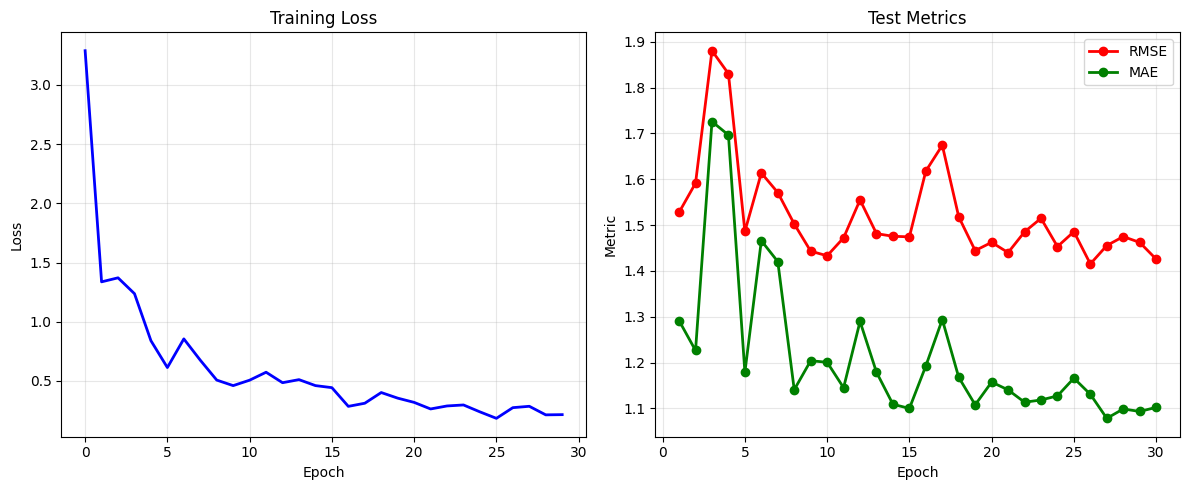

In [28]:
EMBEDDING_DIM = 128
LEARNING_RATE = 0.02
BATCH_SIZE = 64
EPOCHS = 30
RANDOM_SEED = 42

def train_and_evaluate_manual():
    """Обучение модели с заданными параметрами"""
    
    # Фиксация случайности
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    
    # Загрузчики данных
    train_loader_manual = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_manual = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # Модель
    model_manual = RecommenderNN(num_users, num_items, embedding_dim=EMBEDDING_DIM).to(device)
    
    # Оптимизатор и функция потерь
    optimizer_manual = optim.Adam(model_manual.parameters(), lr=LEARNING_RATE)
    criterion_manual = nn.MSELoss()
    
    # Обучение с отслеживанием прогресса
    history = {'train_loss': [], 'test_rmse': [], 'test_mae': []}
    
    for epoch in range(EPOCHS):
        model_manual.train()
        total_loss = 0
        
        for users, items, ratings in train_loader_manual:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            optimizer_manual.zero_grad()
            predictions = model_manual(users, items)
            loss = criterion_manual(predictions, ratings)
            loss.backward()
            optimizer_manual.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader_manual)
        history['train_loss'].append(avg_loss)
        
        # Оценка на тесте каждые 5 эпох
        model_manual.eval()
        test_preds, test_true = [], []
        with torch.no_grad():
            for users, items, ratings in test_loader_manual:
                users, items, ratings = users.to(device), items.to(device), ratings.to(device)
                preds = model_manual(users, items)
                test_preds.extend(preds.cpu().numpy())
                test_true.extend(ratings.cpu().numpy())
            
            test_rmse = math.sqrt(mean_squared_error(test_true, test_preds))
            test_mae = mean_absolute_error(test_true, test_preds)
            history['test_rmse'].append(test_rmse)
            history['test_mae'].append(test_mae)
            
            print(f"Epoch {epoch+1:3d} Train Loss: {avg_loss:.4f} Test RMSE: {test_rmse:.4f} Test MAE: {test_mae:.4f}")
    
    # Финальная оценка
    model_manual.eval()
    final_preds, final_true = [], []
    with torch.no_grad():
        for users, items, ratings in test_loader_manual:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            preds = model_manual(users, items)
            final_preds.extend(preds.cpu().numpy())
            final_true.extend(ratings.cpu().numpy())
    
    final_rmse = math.sqrt(mean_squared_error(final_true, final_preds))
    final_mae = mean_absolute_error(final_true, final_preds)
    
    print("="*60)
    print(f"ФИНАЛЬНЫЕ МЕТРИКИ: RMSE = {final_rmse:.4f}, MAE = {final_mae:.4f}")
    
    return model_manual, history, final_rmse, final_mae


trained_model, history, rmse, mae = train_and_evaluate_manual()

print("\nРЕКОМЕНДАЦИИ ДЛЯ СЛУЧАЙНЫХ ПОЛЬЗОВАТЕЛЕЙ")
print("="*60)

random_users = np.random.choice(df['user_id'].unique(), size=5)

for user_id in random_users:
    user_tensor = torch.tensor([user_id] * num_items, dtype=torch.long).to(device)
    item_tensor = torch.tensor(range(num_items), dtype=torch.long).to(device)
    
    with torch.no_grad():
        predictions = trained_model(user_tensor, item_tensor).cpu().numpy()
    
    top_items = predictions.argsort()[-5:][::-1]
    print(f"User {user_id}: Recommended items {top_items}")

# Визуализация
plt.figure(figsize=(12, 5))

# График Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)

# График RMSE и MAE
plt.subplot(1, 2, 2)
# Создаём оси X по фактической длине данных в history
test_epochs = list(range(1, len(history['test_rmse']) + 1))
plt.plot(test_epochs, history['test_rmse'], 'r-o', label='RMSE', linewidth=2)
plt.plot(test_epochs, history['test_mae'], 'g-o', label='MAE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Test Metrics')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()